# Init

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import json
from scipy.ndimage.interpolation import map_coordinates
import PIL
import cv2
%cd ..
from src.MapData import MapData, min_max_dist, triangle_corr, get_triangular_kernel
from src.LineFinder import LineFinder
from src.plotting_functions import plot_embedding, plot_single_variable_map
from joblib import dump
from time import time
import re

C:\Users\kepes\AppData\Local\Temp\ipykernel_8716\2836221697.py:7: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


d:\Projects\segmentation


# Data

In [167]:
SAMPLES = ['P56B','P36B','P43BII','P49BII','P46BII','P59']
"""
Squamous Cell Carcinoma -- P56
Epithelioid angiosarcoma -- P36
Malignant Melanoma -- P43BII
Pigmented nevus -- P49II
Healthy skin -- P46II
Basal Cell Carcinoma -- P59
"""


'\nSquamous Cell Carcinoma -- P56\nEpithelioid angiosarcoma -- P36\nMalignant Melanoma -- P43BII\nPigmented nevus -- P49II\nHealthy skin -- P46II\nBasal Cell Carcinoma -- P59\n'

In [212]:
sample = SAMPLES[4]
print(sample)

P46BII


## ICP

In [213]:
icp_data_folder = Path('D:/Projects/segmentation/data/ICP/2022_04_19')
icp_data_path = icp_data_folder.joinpath(f"{sample}/Export")
icp_data = {}
for file_path in icp_data_path.glob('*matrix.csv'):
    element = re.search(
      ' [A-Z][a-z]{0,1}',
      file_path.name
    )\
      .group(0)\
      .strip()
    print(element)
    loaded_data = pd.read_csv(
        file_path,
        header=None
    )
    loaded_data = loaded_data.loc[
        ~loaded_data\
          .isna()\
          .apply(lambda x: all(x), axis=1),
        ~loaded_data\
          .isna()\
          .apply(lambda x: all(x), axis=0)
    ]
    icp_data[element] = loaded_data.fillna(0)
    # icp_data[element] = loaded_data

Au
C
Ca
Cu
Fe
Mg
P
To
Zn


## LIBS

In [217]:
libs_dir = Path(f"D:/Projects/segmentation/data/Rakoviny/{sample}")
libs_path = list(libs_dir.glob('*.libsdata'))
print(libs_path)

[WindowsPath('D:/Projects/segmentation/data/Rakoviny/P46BII/448x747_2022_03_16_P46B_II.libsdata'), WindowsPath('D:/Projects/segmentation/data/Rakoviny/P46BII/721x436-P46BII-Avantes.libsdata')]


In [219]:
libs_map_data = MapData(
    # libs_path[1],
    libs_path[0],
    overwrite=False
)
libs_map_data.get_metadata()
libs_map_data.load_wavelenths()
libs_map_data.get_map_dimensions()
libs_map_data.load_all_data('baseline_corrected')
libs_map_data.trim_spectra(64)
libs_map_data.get_baseline(
    min_window_size=50,
    smooth_window_size=100
)
libs_map_data.baseline_correct()
libs_map_data.upsample_spectra()

if libs_map_data.systemic_noise_spectrum is not None:
    libs_map_data.denoise_spectra(
        file_name_supplement='preprocessed',
        threshold=np.std(libs_map_data.systemic_noise_spectrum),
        level=9
    )

maxima_spectrum = libs_map_data.spectra.max(axis=0)
print('finding lines')
line_finder = LineFinder(
    maxima_spectrum,
    libs_map_data.wvl,
    name='maxima'
)
line_finder.find_lines()
line_finder.load_nist_tables(
    Path('D:/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
)
line_finder.find_peaks_in_reference(
    maxima_spectrum,
    scale=False,
    show_cond=False
)

libs_map_data.set_emission_line_parameters(
    line_finder.peaks[1].get('left_bases'),
    line_finder.peaks[1].get('right_bases'),
    line_centers=line_finder.peaks[0]
)
libs_map_data.set_emisssion_line_functions(
    intensity_funcs=[np.max,np.sum,min_max_dist,] #triangle_corr
)
# libs_map_data.save_spectra('baseline_corrected')
print('integrating emission line intensities')
libs_map_data.get_emission_line_intensities()

line_finder.plot_found_lines()

loading metadata
loading wavelengths
getting map dimensions
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines
upsampling spectra
finding lines
creating base plot
integrating emission line intensities
extracting emission line intensities using amax
extracting emission line intensities using sum
extracting emission line intensities using min_max_dist
converting line intensities to lists
saving emission line intensities


## Colormap

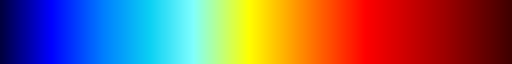

In [11]:
loaded_colors = pd.read_csv('D:/Projects/segmentation/data/mozna_dobra.colmap')
loaded_colors = [tuple(int(h[i:i+2], 16)/255 for i in (2, 4, 6)) for h in loaded_colors.iloc[:500,0].astype(str)]
loaded_colors.reverse()
loaded_colors

cmap = LinearSegmentedColormap.from_list(
    'fromHana', 
    loaded_colors, 
    N=1000
)
cmap

# Correlations

## ICP vs ICP

In [215]:
def quantile_process_map(
    input_map: np.ndarray,
    rotate: int = 0,
    transpose: bool = False
):
    cutoff_quantile = .99

    input_map = input_map.copy()
    input_map -= input_map.min().min()

    counts, bin_centers = np.histogram(
        input_map,
        bins=100
    )
    
    total_counts = np.sum(counts)
    cutoff_bin = bin_centers[:-1][
        np.cumsum(counts) >= (total_counts * cutoff_quantile)
    ][0]
    if cutoff_bin == bin_centers[0]:
        cutoff_bin = bin_centers[1]

    input_map[input_map > cutoff_bin] = cutoff_bin
    # input_map[input_map < bin_centers[int(100 - (cutoff_quantile * 100))]] = 0

    input_map /= input_map.max().max()
    input_map *= 255

    if transpose:
        input_map = np.transpose(input_map)
    if rotate != 0:
        input_map = np.rot90(input_map, k=rotate)
    plt.imshow(input_map, cmap=cmap)

    return input_map

          Mg         P        Zn
Mg  1.000000  0.196577  0.340781
P   0.196577  1.000000  0.149748
Zn  0.340781  0.149748  1.000000


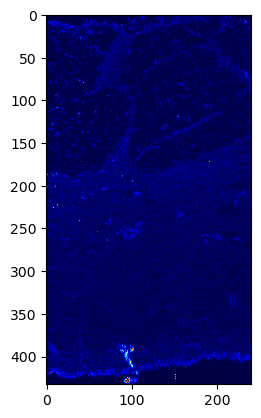

In [221]:
icp_elements = ['Mg','P','Zn']
# icp_elements = ['C','Cu','Fe','Mg','P','S','Zn']
icp_correlation_matrix = np.zeros((len(icp_elements),len(icp_elements)))

for row_ndx,reference_element in enumerate(icp_elements):
    for col_ndx,comparison_element in enumerate(icp_elements):
        icp_correlation_matrix[row_ndx, col_ndx] = np.corrcoef(
            quantile_process_map(
                input_map=icp_data[reference_element],
                transpose=True
            )\
              .to_numpy()\
              .reshape(-1),
            quantile_process_map(
                input_map=icp_data[comparison_element],
                transpose=True
            )\
              .to_numpy()\
              .reshape(-1)
        )[0,1]

icp_corr_matrix = pd.DataFrame(
  icp_correlation_matrix,
  index=icp_elements,
  columns=icp_elements
)
icp_corr_matrix.to_csv(
  'D:/Projects/segmentation/temp/icp_correlation_matrix.csv'
)
print(icp_corr_matrix)

## LIBS

279.63


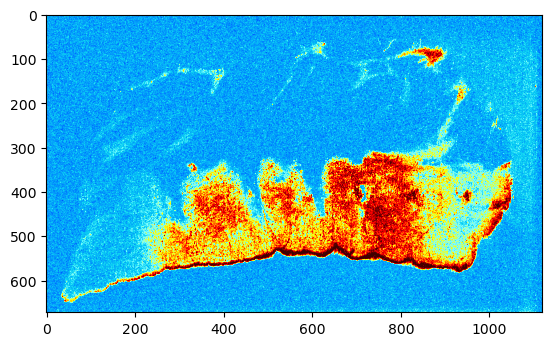

In [224]:
method = 'min_max_dist'
# method = 'triangle_corr'
compared_element = 'Mg'

libs_rotate = 1
libs_transpose = False

libs_lines = {
    'Zn':[330.25,334.50,472.22,481.06],
    'Mg':[285.21,279.55,279.81,280.27],
    'Ca':[422.67,317.96,315.92,393.00],
    'P':[253.57,255.33,213.62,214.92],
}

matching_libs_lines = {}
detected_libs_lines = list(
    libs_map_data.line_intensities[method].keys()
)
detected_libs_lines = np.array(detected_libs_lines).astype(float)
for element in libs_lines:
    matching_libs_lines[element] = [
        detected_libs_lines[np.argmin(np.abs(detected_libs_lines - x))]
        for x
        in libs_lines[element]
    ]

line_center = str(matching_libs_lines[compared_element][2])
if len(line_center) != 6:
    line_center = f"{line_center}0"

print(line_center)

libs_map = libs_map_data.vector_to_array(
    libs_map_data.line_intensities[method][line_center]
)
# Define the new dimensions
new_dims = []
for original_length, new_length in zip(
    libs_map.shape, 
    [int(x  * 1.5) for x in libs_map.shape]
):
    new_dims.append(np.linspace(0, original_length-1, new_length))

coords = np.meshgrid(*new_dims, indexing='ij')
upscaled_libs_map_for_matching = map_coordinates(libs_map, coords)
upscaled_libs_map_for_matching[upscaled_libs_map_for_matching < 0] = 0
upscaled_libs_map_for_matching = quantile_process_map(
    input_map=upscaled_libs_map_for_matching,
    rotate=libs_rotate,
    transpose=libs_transpose
)

### Overlap

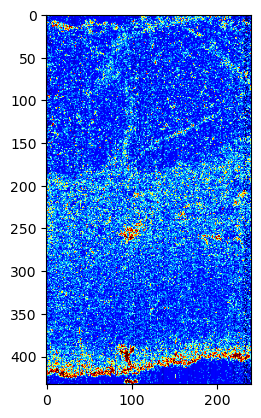

In [225]:
icp_map = quantile_process_map(icp_data['Mg'],transpose=True,rotate=False)

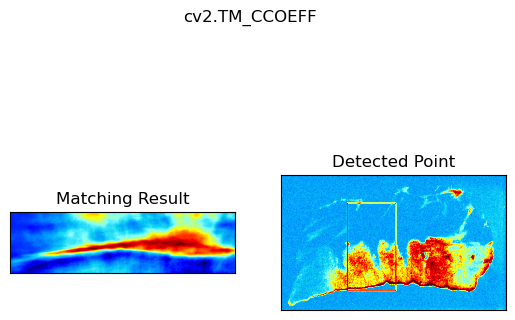

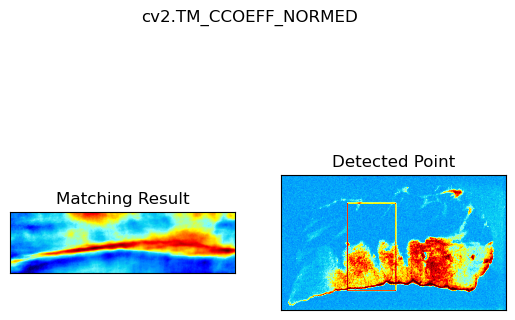

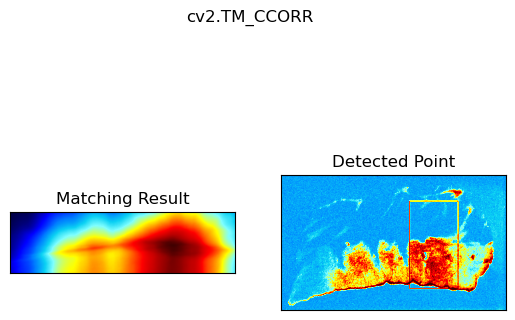

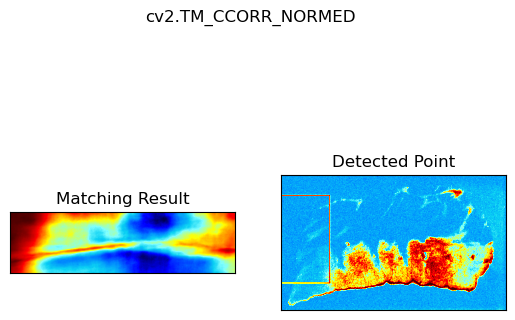

In [226]:
# https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

methods = [
    'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
    'cv2.TM_CCORR_NORMED', #'cv2.TM_SQDIFF', #'cv2.TM_SQDIFF_NORMED'
]

image = upscaled_libs_map_for_matching.astype(np.uint8)
template = icp_map.values.astype(np.uint8)

libs_subsets = []
w, h = template.shape[::-1]
for meth in methods:
    img = image.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)

    libs_subsets.append(
        [top_left[1],bottom_right[1],top_left[0],bottom_right[0]]
    )
    
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap=cmap)
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap=cmap)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

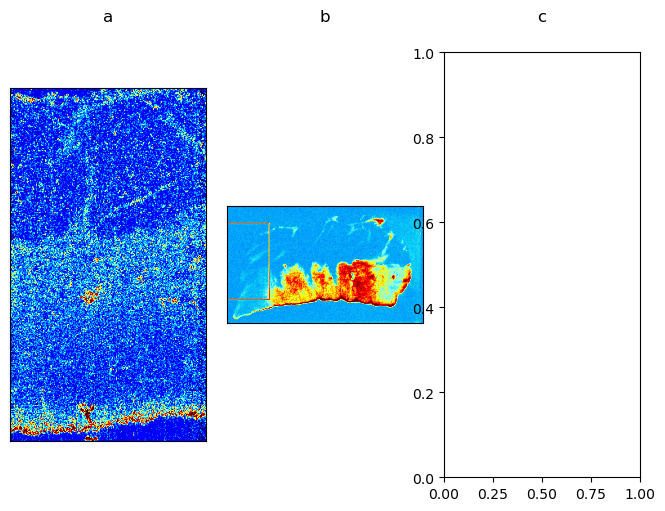

In [227]:
final_fig = plt.figure(
  constrained_layout=True, 
  figsize=(16/2.54, 12/2.54)
)

subfigures = final_fig.subfigures(1, 3, wspace=0.1)

ax1 = subfigures[0].add_axes([0, 0, 1, 0.9])
ax1.set_aspect('equal')
ax2 = subfigures[1].add_axes([0, 0, 1, 0.9])
ax2.set_aspect('equal')
ax3 = subfigures[2].add_axes([0, 0, 1, 0.9])

ax1.imshow(template,cmap=cmap,vmin=0,vmax=255)
ax1.set_xticks([])
ax1.set_xticks([], minor=True)
ax1.set_yticks([])
ax1.set_yticks([], minor=True)
ax2.imshow(img,cmap=cmap,vmin=0,vmax=255)
ax2.set_xticks([])
ax2.set_xticks([], minor=True)
ax2.set_yticks([])
ax2.set_yticks([], minor=True)

for i in range(3):
  subfigures[i].suptitle('abc'[i])

0.14933912794678278
0.14933912794678278
0.1033901238044256
0.03592809785205453


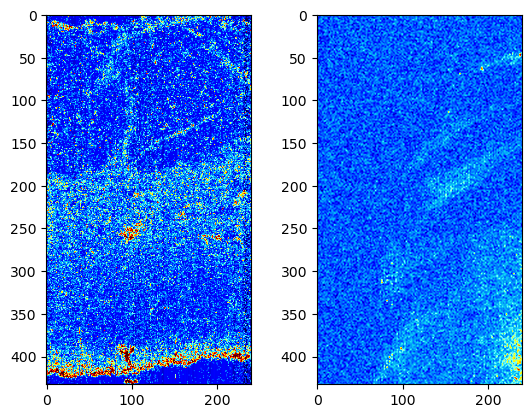

In [229]:
for libs_subset in libs_subsets:
    libs_match = image[libs_subset[0]:libs_subset[1],libs_subset[2]:libs_subset[3]].copy()

    print(np.corrcoef(
        template.reshape(-1),
        libs_match.reshape(-1)
    )[0,1])
    
fig,ax = plt.subplots(ncols=2)
ax[0].imshow(template,cmap=cmap)
ax[1].imshow(libs_match,cmap=cmap)

libs_subset = libs_subsets[0]

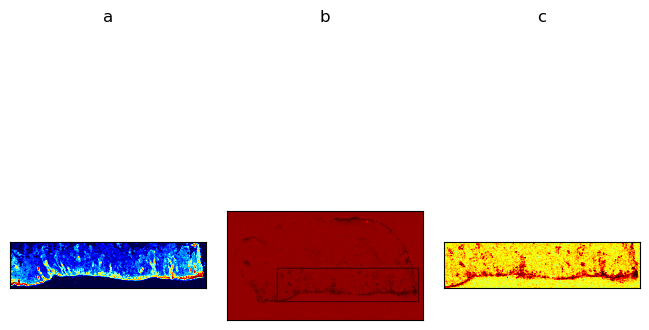

In [46]:
ax3.imshow(libs_match,cmap=cmap)
ax3.set_aspect('equal')
ax3.set_xticks([])
ax3.set_xticks([], minor=True)  
ax3.set_yticks([])
ax3.set_yticks([], minor=True)
final_fig

### Affine correction

0.10237495353146173
0.15844743013947313


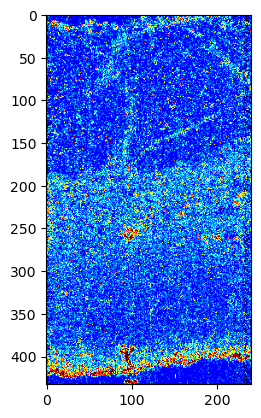

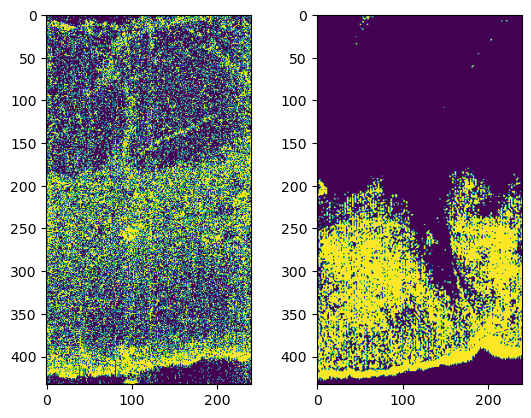

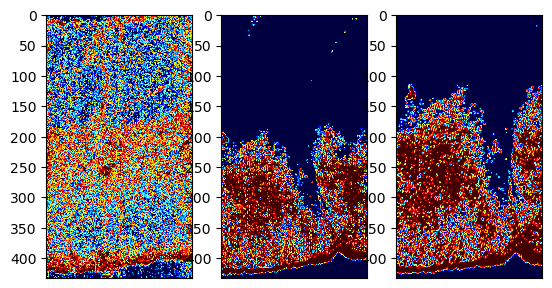

In [231]:
THRESHOLD_LOW = 40
THRESHOLD_HIGH = 255

libs_image = quantile_process_map(
    upscaled_libs_map_for_matching[libs_subset[0]:libs_subset[1],libs_subset[2]:libs_subset[3]]
)
icp_image = quantile_process_map(
    icp_map.values
)

counts, bin_centers = np.histogram(
    libs_image.reshape(-1),
    bins=100
)


icp_th, icp_im_th = cv2.threshold(
    icp_image, 
    THRESHOLD_LOW,
    THRESHOLD_HIGH,
    cv2.THRESH_BINARY
)
libs_th, libs_im_th = cv2.threshold(
    libs_image, 
    bin_centers[:-1][np.cumsum(counts) > (icp_image < THRESHOLD_LOW).sum()][10],
    THRESHOLD_HIGH,
    cv2.THRESH_BINARY
)

fig,ax = plt.subplots(ncols=2)
ax[0].imshow(icp_im_th)
ax[1].imshow(libs_im_th)

# Find size of image1
sz = libs_im_th.shape
# Define the motion model
warp_mode = cv2.MOTION_AFFINE 
# Specify the number of iterations.
number_of_iterations = 5000 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10
# Define termination criteria
criteria = (
    cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
    number_of_iterations,  
    termination_eps
)
# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY:
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else:
    warp_matrix = np.eye(2, 3, dtype=np.float32)
 
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC(
    icp_im_th.astype(np.float32),
    libs_im_th.astype(np.float32),
    warp_matrix,
    warp_mode,
    criteria
)
 
if warp_mode == cv2.MOTION_HOMOGRAPHY:
# Use warpPerspective for Homography
    libs_im_th_aligned = cv2.warpPerspective(
        libs_im_th.astype(np.float32),
        warp_matrix,
        (sz[1],sz[0]), 
        flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
    )
else:
# Use warpAffine for Translation, Euclidean and Affine
    libs_im_th_aligned = cv2.warpAffine(
        libs_im_th.astype(np.float32),
        warp_matrix,
        (sz[1],sz[0]), 
        flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
    )
 
# Show final results
fig,ax = plt.subplots(ncols=3)
ax[0].imshow(icp_im_th,cmap=cmap)
ax[1].imshow(libs_im_th,cmap=cmap)
ax[2].imshow(libs_im_th_aligned,cmap=cmap)
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_xticks([], minor=True)

print(np.corrcoef(
    icp_im_th.reshape(-1),
    libs_im_th.reshape(-1)
)[0,1])
print(np.corrcoef(
    icp_im_th.reshape(-1),
    libs_im_th_aligned.reshape(-1)
)[0,1])

Mg seeked: 285.21, found: 285.30
full
0.06832754961096756
0.08614945723102194
thresholded
0.07001210047854856
0.0861510632038584
rescaled
0.08485547638505334
Mg seeked: 279.55, found: 279.63
full
0.09229629002133528
0.10265723091282039
thresholded
0.08058249797614289
0.09450686526655948
rescaled
0.09414750885307635
Mg seeked: 279.81, found: 279.63
full
0.09229629002133528
0.10265723091282039
thresholded
0.08058249797614289
0.09450686526655948
rescaled
0.09414750885307635
Mg seeked: 280.27, found: 280.31
full
0.09081727139887452
0.09920339584434465
thresholded
0.08098153508486544
0.09274796436904756
rescaled
0.09242726270987797


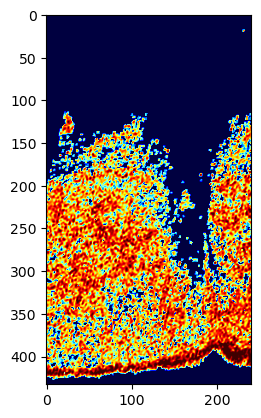

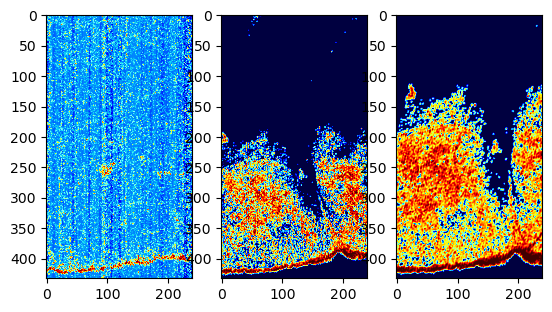

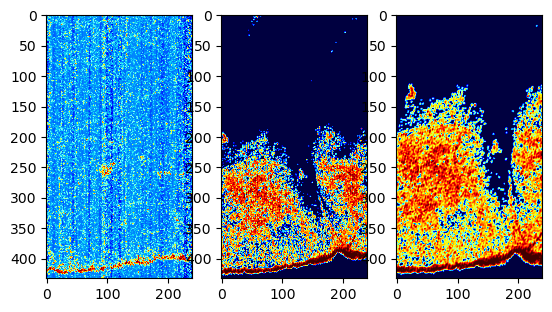

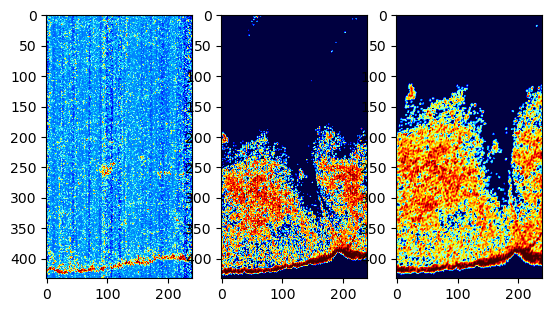

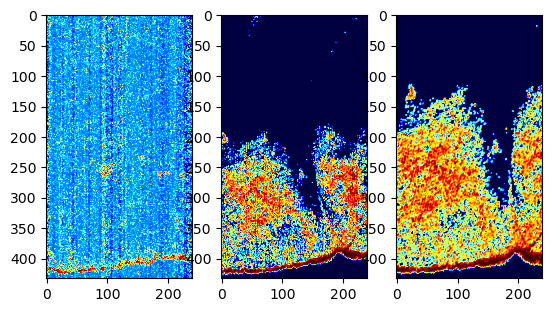

In [234]:
intensity_method = 'min_max_dist'
libs_lines = {
    # 'Zn':[330.25,334.50],
    'Mg':[285.21,279.55,279.81,280.27],
    # 'Ca':[317.96,315.92,393.00],
    # 'P':[253.57,255.33],
}

icp_image = quantile_process_map(
    icp_data['P'].values,
    transpose=True
)

matching_libs_lines = {}
detected_libs_lines = list(
    libs_map_data.line_intensities[intensity_method].keys()
)
detected_libs_lines = np.array(detected_libs_lines).astype(float)
for element,line_centers in libs_lines.items():
    for line_center in line_centers:
        matching_libs_line = detected_libs_lines[
            np.argmin(np.abs(detected_libs_lines - line_center))
        ]
        matching_libs_line = str(matching_libs_line)
        if len(matching_libs_line) != 6:
            matching_libs_line = f"{matching_libs_line}0"
        print(f"{element} seeked: {line_center}, found: {matching_libs_line}")

        libs_map = libs_map_data.vector_to_array(
            libs_map_data.line_intensities[intensity_method][matching_libs_line]
        )
        upscaled_libs_map = map_coordinates(libs_map, coords)
        upscaled_libs_map = quantile_process_map(
            input_map=upscaled_libs_map,
            rotate=libs_rotate,
            transpose=libs_transpose
        )

        libs_image = quantile_process_map(
            upscaled_libs_map[libs_subset[0]:libs_subset[1],libs_subset[2]:libs_subset[3]]
        )

        if warp_mode == cv2.MOTION_HOMOGRAPHY:
        # Use warpPerspective for Homography
            libs_image_aligned = cv2.warpPerspective(
                libs_image, 
                warp_matrix, 
                (sz[1],sz[0]), 
                flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
            )
        else:
        # Use warpAffine for Translation, Euclidean and Affine
            libs_image_aligned = cv2.warpAffine(
                libs_image, 
                warp_matrix, 
                (sz[1],sz[0]),
                flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
            )
        
        print('full')
        print(np.corrcoef(
            icp_image.reshape(-1),
            libs_image.reshape(-1)
        )[0,1])
        print(np.corrcoef(
            icp_image.reshape(-1),
            libs_image_aligned.reshape(-1)
        )[0,1])

        libs_image_aligned[~libs_im_th_aligned.astype(bool)] = 0
        libs_image[~libs_im_th.astype(bool)] = 0

        print('thresholded')
        print(np.corrcoef(
            icp_image.reshape(-1),
            libs_image.reshape(-1)
        )[0,1])
        print(np.corrcoef(
            icp_image.reshape(-1),
            libs_image_aligned.reshape(-1)
        )[0,1])
        
        print('rescaled')
        libs_image_aligned = quantile_process_map(
            input_map=libs_image_aligned,
            rotate=False,
            transpose=False
        )
        print(np.corrcoef(
            icp_image.reshape(-1),
            libs_image_aligned.reshape(-1)
        )[0,1])

        # Show final results
        fig,ax = plt.subplots(ncols=3)
        ax[0].imshow(icp_image,cmap=cmap)
        ax[1].imshow(libs_image,cmap=cmap)
        ax[2].imshow(libs_image_aligned,cmap=cmap)

In [24]:
print(np.corrcoef(
    libs_map_data.line_intensities[intensity_method]['279.63'].reshape(-1),
    libs_map_data.line_intensities[intensity_method]['393.34'].reshape(-1)
)[0,1])

0.357897277904915
